In [1]:
import tensorflow as tf
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2.6.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
from PIL import Image
import numpy as np
import cv2
from skimage import transform
from keras.preprocessing.image import img_to_array
import tensorflow as tf
import shutil
import os


imsize = (128,96)

x1_train = []
for archivo in os.listdir('dataset_sunrgbd/train_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/train_rgb',archivo))
    img = cv2.resize(img_to_array(img), dsize=imsize)
    x1_train.append(np.asarray(img))
x1_train = np.array(x1_train)
x1_train = x1_train/255.0
print(x1_train.shape)

x1_test = []
for archivo in os.listdir('dataset_sunrgbd/test_rgb'):
    img = Image.open(os.path.join('dataset_sunrgbd/test_rgb',archivo))
    img = cv2.resize(img_to_array(img), dsize=imsize)
    x1_test.append(np.asarray(img))
x1_test = np.array(x1_test)
x1_test = x1_test/255.0
print(x1_test.shape)

x2_train = []
for archivo in os.listdir('dataset_sunrgbd/train_depth'):
    img = Image.open(os.path.join('dataset_sunrgbd/train_depth',archivo))
    img = cv2.resize(cv2.cvtColor(img_to_array(img),cv2.COLOR_GRAY2RGB), dsize=imsize)
#     img = cv2.cvtColor(img_to_array(img),cv2.COLOR_GRAY2RGB)
    x2_train.append(np.asarray(img))
x2_train = np.array(x2_train)
x2_train = x2_train/26000
print(x2_train.shape)

x2_test = []
for archivo in os.listdir('dataset_sunrgbd/test_depth'):
    img = Image.open(os.path.join('dataset_sunrgbd/test_depth',archivo))
    img = cv2.resize(cv2.cvtColor(img_to_array(img),cv2.COLOR_GRAY2RGB), dsize=imsize)
#     img = cv2.cvtColor(img_to_array(img),cv2.COLOR_GRAY2RGB)
    x2_test.append(np.asarray(img))
x2_test = np.array(x2_test)
x2_test = x2_test/26000.0
print(x2_test.shape)

y_train = []
for archivo in os.listdir('dataset_sunrgbd/train_label'):
    img = np.load(os.path.join('dataset_sunrgbd/train_label',archivo))
    img = cv2.resize(img_to_array(img), dsize=imsize)
    y_train.append(img)
y_train = np.array(y_train).astype('uint8')
y_train = tf.keras.utils.to_categorical(y_train, dtype='float32')
print(y_train.shape)

y_test = []
for archivo in os.listdir('dataset_sunrgbd/test_label'):
    img = np.load(os.path.join('dataset_sunrgbd/test_label',archivo))
    img = cv2.resize(img_to_array(img), dsize=imsize)
    y_test.append(img)
y_test = np.array(y_test).astype('uint8')
y_test = tf.keras.utils.to_categorical(y_test, dtype='float32')
print(y_test.shape)

del img


(587, 96, 128, 3)
(572, 96, 128, 3)
(587, 96, 128, 3)
(572, 96, 128, 3)
(587, 96, 128, 38)
(572, 96, 128, 38)


In [3]:
from sklearn.model_selection import train_test_split

x = np.array(list(zip(x1_test, x2_test)))
del x1_test, x2_test

x_test, x_val, y_test, y_val = train_test_split(x,y_test,test_size=0.2)

x1_test, x2_test = x_test[:, 0], x_test[:, 1]
x1_val, x2_val = x_val[:, 0], x_val[:, 1]

del x_test, x_val

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=15,
        shear_range=0.02,
        zoom_range=[0.9, 1.25],
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode="reflect") #'nearest'
val_datagen = ImageDataGenerator()

In [5]:
train_datagen.fit(x1_train)
val_datagen.fit(x1_val)

In [6]:
train = train_datagen.flow([x1_train, x2_train], y_train, batch_size=16)
validation = val_datagen.flow([x1_val, x2_val], y_val, batch_size=8)

In [7]:
import matplotlib.pyplot as plt

def plot_color(ax, color, title="Color"):
    """Displays a color image from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(color)

def plot_depth(ax, depth, title="Depth"):
    """Displays a depth map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(depth, cmap='Spectral')

def plot_label(ax, labels, title="Label"):
    """Displays a label map from the NYU dataset."""

    ax.axis('off')
    ax.set_title(title)
    ax.imshow(labels)

0.90991527


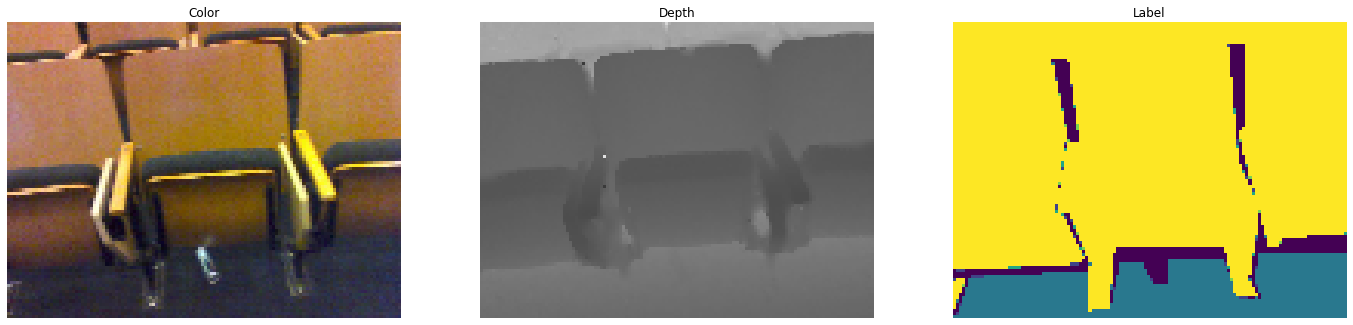

In [8]:
fig = plt.figure("Labeled Dataset Sample", figsize=(24, 10))

number = 1

ax = fig.add_subplot(1, 3, 1)
plot_color(ax, x1_train[1])

ax = fig.add_subplot(1, 3, 2)
plot_depth(ax, x2_train[1])
print(np.max(x2_train[0]))

ax = fig.add_subplot(1, 3, 3)
plot_label(ax, np.argmax(y_train[1],axis=-1))

plt.show()

In [9]:
class MyModel():

    def __init__(self):
        '''
        Crear el modelos para segmentación
        '''
        self.input_rgb = tf.keras.layers.Input(shape=(96,128,3),dtype=tf.float32,name='input_1')
        self.input_depth = tf.keras.layers.Input(shape=(96,128,3),dtype=tf.float32,name='input_2')
        self.fusion_1 = None
        self.fusion_2 = None
        self.fusion_3 = None

    def rgbd_fusion(self,input_r,input_d,capa):
        r = tf.keras.layers.GlobalAveragePooling2D()(input_r)
        r = tf.keras.layers.Reshape((1,1,64*capa))(r)
        r = tf.keras.layers.Conv2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu')(r)
        r = tf.keras.layers.Conv2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(r)
        m_1 = tf.keras.layers.Multiply()([input_r,r])
        
        d = tf.keras.layers.GlobalAveragePooling2D()(input_d)
        d = tf.keras.layers.Reshape((1,1,64*capa))(d)
        d = tf.keras.layers.Conv2D(4*capa,kernel_size=(1,1),strides=(1,1),activation='relu')(d)
        d = tf.keras.layers.Conv2D(64*capa,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(d)
        m_2 = tf.keras.layers.Multiply()([input_d,d])
        
        return tf.keras.layers.Add()([m_1,m_2])

    def resnet_layer(self,input_res, input_add, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)
        
        return x
    
    def resnet_layer_div(self,input_res, input_add, filters):
        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same', strides=(2,1))(input_res)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        
        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same', strides=(1,2))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (3, 1), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)

        x = tf.keras.layers.Conv2D(filters, (1, 3), padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('relu')(x)
        x = tf.keras.layers.Add()([input_add,x])
        x = tf.keras.layers.Activation('relu')(x)

        return x
    
    def bottleneck_layer(self,input_bo,filters):
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 1), activation='relu', padding='same')(input_bo)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 1), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Conv2D(filters, kernel_size=(1, 3), activation='relu', padding='same')(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Add()([x, input_bo])
        x = tf.keras.layers.Activation('relu')(x)
        return x

    def decode_layer(self,input_de,input_add,filters):
        x = tf.keras.layers.Conv2D(filters,kernel_size=(3,3),activation='relu', padding='same')(input_de)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = self.bottleneck_layer(x, filters)
        x = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(x)
        x_2 = tf.keras.layers.Conv2D(filters, kernel_size=(1, 1), activation='relu', padding='same')(input_add)
        x = tf.keras.layers.Add()([x, x_2])

        return x
        
    def model(self):

        # Preparar la entrada de datos
        xr = tf.keras.layers.Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu')(self.input_rgb)
        xd = tf.keras.layers.Conv2D(64,kernel_size=(7,7),strides=(2,2),padding='same',dilation_rate=(1,1),activation='relu')(self.input_depth)

        # Fusion
        xr = self.rgbd_fusion(xr,xd,1)

        # Preparar para encoder
        xr = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(xr)
        xd = tf.keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2), padding='same')(xd)

        ''' ENCODER'''
        # PRIMERA CAPA
        xr = self.resnet_layer(xr,xr,64)
        xd = self.resnet_layer(xd,xd,64)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,1)
        self.fusion_1 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # SEGUNDA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2))(xr),128)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(128,kernel_size=(1,1),strides=(2,2))(xd),128)

        n = 3 # las veces que se repite el resnet_layer
        for k in range(n):
            xr = self.resnet_layer(xr,xr,128)
            xd = self.resnet_layer(xd,xd,128)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,2)
        self.fusion_2 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # TERCERA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(256,kernel_size=(1,1),strides=(2,2))(xr),256)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(256,kernel_size=(1,1),strides=(2,2))(xd),256)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,4)
        self.fusion_3 = xr  # Aqui guardamos la fusion realizada despues de la capa resnet. Esto lo utilizaremos para decodificar.

        # CUARTA CAPA
        xr = self.resnet_layer_div(xr,tf.keras.layers.Conv2D(512,kernel_size=(1,1),strides=(2,2))(xr),512)
        xd = self.resnet_layer_div(xd,tf.keras.layers.Conv2D(512,kernel_size=(1,1),strides=(2,2))(xd),512)
            
        # Fusion despues de Resnet
        xr = self.rgbd_fusion(xr,xd,8)

        '''DECODER'''

        xr = self.decode_layer(xr,self.fusion_3,512)
        xr = self.decode_layer(xr,self.fusion_2,256)
        xr = self.decode_layer(xr,self.fusion_1,128)
        
        xr = tf.keras.layers.Conv2D(38, kernel_size=(3, 3), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(xr)
        xr = tf.keras.layers.Conv2D(38, kernel_size=(1, 1), activation='relu', padding='same')(xr)
        xr = tf.keras.layers.UpSampling2D(size=(2,2), interpolation="nearest")(xr)
        xr = tf.keras.layers.Conv2D(38, kernel_size=(1, 1), activation='relu', padding='same')(xr)

        return tf.keras.Model(inputs=[self.input_rgb, self.input_depth], outputs=xr)

In [10]:
model = MyModel().model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 48, 64, 64)   9472        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 48, 64, 64)   9472        input_2[0][0]                    
______________________________________________________________________________________________

In [11]:
tf.keras.utils.plot_model(model,to_file="model.png")

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [12]:
def plot_acc(history, title="Model Accuracy"):
    """Imprime una gráfica mostrando la accuracy por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    
def plot_loss(history, title="Model Loss"):
    """Imprime una gráfica mostrando la pérdida por epoch obtenida en un entrenamiento"""
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper right')
    plt.show()
    
def plot_compare_losses(history1, history2, name1="Red 1",
                        name2="Red 2", title="Graph title"):
    """Compara losses de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['loss'], color="green")
    plt.plot(history1.history['val_loss'], 'r--', color="green")
    plt.plot(history2.history['loss'], color="blue")
    plt.plot(history2.history['val_loss'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2],
               loc='upper right')
    plt.show()
    
def plot_compare_accs(history1, history2, name1="Red 1",
                      name2="Red 2", title="Graph title"):
    """Compara accuracies de dos entrenamientos con nombres name1 y name2"""
    plt.plot(history1.history['accuracy'], color="green")
    plt.plot(history1.history['val_accuracy'], 'r--', color="green")
    plt.plot(history2.history['accuracy'], color="blue")
    plt.plot(history2.history['val_accuracy'], 'r--', color="blue")
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train ' + name1, 'Val ' + name1, 
                'Train ' + name2, 'Val ' + name2], 
               loc='lower right')
    plt.show()

In [13]:
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection)/ (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)
#seg_model.compile(optimizer=Adam(1e-4, decay=1e-6), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [14]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
import math
weight_path="{}_best_weights.hdf5".format('seg_model_2')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=1, 
                                   verbose=1, min_delta=0.0001, cooldown=2)
def step_decay(epoch):
    initial_lrate = 0.005
    drop = 1.0
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    if epoch %10 ==0:
        print('New lr is: ', lrate)
    return lrate

lrate = LearningRateScheduler(step_decay)

early = EarlyStopping(monitor="val_loss",
                      patience=10) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, lrate]

In [15]:
from segmentation_models.metrics import iou_score

model.compile(optimizer='SGD', loss=dice_loss, 
              metrics=[dice_coef, 
                       'accuracy', 
                       true_positive_rate, 
                       iou_score
                      ])

history = model.fit(train, epochs=1000, verbose=1, validation_data=validation, callbacks=callbacks_list)

Segmentation Models: using `keras` framework.
Epoch 1/1000
New lr is:  0.005
37/37 [==============================] - 25s 409ms/step - loss: 0.8828 - dice_coef: 0.0832 - accuracy: 0.1678 - true_positive_rate: 1.6903 - iou_score: 0.0270 - val_loss: 0.8820 - val_dice_coef: 0.1785 - val_accuracy: 0.2202 - val_true_positive_rate: 0.2488 - val_iou_score: 0.0536

Epoch 00001: val_loss improved from inf to 0.88201, saving model to seg_model_2_best_weights.hdf5
Epoch 2/1000
New lr is:  0.005
37/37 [==============================] - 11s 291ms/step - loss: 0.8449 - dice_coef: 0.0907 - accuracy: 0.2105 - true_positive_rate: 2.6523 - iou_score: 0.0410 - val_loss: 0.8680 - val_dice_coef: 0.1937 - val_accuracy: 0.2204 - val_true_positive_rate: 0.3187 - val_iou_score: 0.0602

Epoch 00002: val_loss improved from 0.88201 to 0.86798, saving model to seg_model_2_best_weights.hdf5
Epoch 3/1000
New lr is:  0.005
37/37 [==============================] - 11s 291ms/step - loss: 0.8192 - dice_coef: 0.0987 - ac


Epoch 00020: val_loss improved from 0.45742 to 0.44300, saving model to seg_model_2_best_weights.hdf5
Epoch 21/1000
New lr is:  0.00125
37/37 [==============================] - 11s 290ms/step - loss: 0.4698 - dice_coef: 0.2852 - accuracy: 0.2691 - true_positive_rate: 6.4626 - iou_score: 0.0519 - val_loss: 0.4246 - val_dice_coef: 0.2820 - val_accuracy: 0.2779 - val_true_positive_rate: 15.9109 - val_iou_score: 0.0687

Epoch 00021: val_loss improved from 0.44300 to 0.42456, saving model to seg_model_2_best_weights.hdf5
Epoch 22/1000
New lr is:  0.00125
37/37 [==============================] - 11s 288ms/step - loss: 0.4560 - dice_coef: 0.2847 - accuracy: 0.2738 - true_positive_rate: 6.2707 - iou_score: 0.0505 - val_loss: 0.3936 - val_dice_coef: 0.2846 - val_accuracy: 0.2834 - val_true_positive_rate: 13.8172 - val_iou_score: 0.0680

Epoch 00022: val_loss improved from 0.42456 to 0.39364, saving model to seg_model_2_best_weights.hdf5
Epoch 23/1000
New lr is:  0.00125
37/37 [================

Epoch 41/1000
New lr is:  0.0003125
37/37 [==============================] - 11s 291ms/step - loss: -0.0382 - dice_coef: 0.2046 - accuracy: 0.3040 - true_positive_rate: 4.1299 - iou_score: 0.0607 - val_loss: -0.2194 - val_dice_coef: 0.2415 - val_accuracy: 0.3226 - val_true_positive_rate: 7.9983 - val_iou_score: 0.1159

Epoch 00041: val_loss improved from -0.20059 to -0.21936, saving model to seg_model_2_best_weights.hdf5
Epoch 42/1000
New lr is:  0.0003125
37/37 [==============================] - 11s 291ms/step - loss: -0.0511 - dice_coef: 0.2030 - accuracy: 0.3029 - true_positive_rate: 4.2013 - iou_score: 0.0691 - val_loss: -0.2005 - val_dice_coef: 0.2410 - val_accuracy: 0.3229 - val_true_positive_rate: 8.0396 - val_iou_score: 0.1196

Epoch 00042: val_loss did not improve from -0.21936
Epoch 43/1000
New lr is:  0.0003125
37/37 [==============================] - 11s 297ms/step - loss: -0.0565 - dice_coef: 0.2024 - accuracy: 0.3036 - true_positive_rate: 4.2168 - iou_score: 0.0636 - val_


Epoch 00083: val_loss did not improve from -0.29047
Epoch 84/1000
New lr is:  1.953125e-05
37/37 [==============================] - 11s 291ms/step - loss: -0.1862 - dice_coef: 0.1923 - accuracy: 0.3003 - true_positive_rate: 4.7202 - iou_score: 0.0898 - val_loss: -0.2613 - val_dice_coef: 0.2260 - val_accuracy: 0.3202 - val_true_positive_rate: 7.9563 - val_iou_score: 0.1332

Epoch 00084: val_loss did not improve from -0.29047
Epoch 85/1000
New lr is:  1.953125e-05
37/37 [==============================] - 11s 290ms/step - loss: -0.1902 - dice_coef: 0.1929 - accuracy: 0.3010 - true_positive_rate: 4.7683 - iou_score: 0.0862 - val_loss: -0.2824 - val_dice_coef: 0.2268 - val_accuracy: 0.3206 - val_true_positive_rate: 7.9447 - val_iou_score: 0.1431

Epoch 00085: val_loss did not improve from -0.29047
Epoch 86/1000
New lr is:  1.953125e-05
37/37 [==============================] - 11s 290ms/step - loss: -0.1904 - dice_coef: 0.1920 - accuracy: 0.2997 - true_positive_rate: 4.7496 - iou_score: 0.0

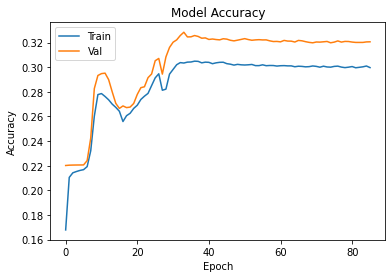

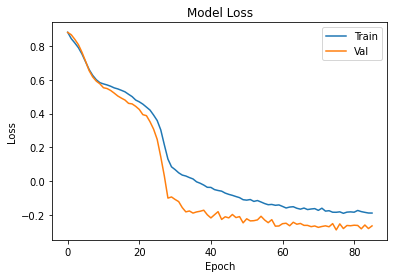

In [16]:
plot_acc(history)
plot_loss(history)

In [17]:
score = model.evaluate([x1_test,x2_test], y_test, verbose = 0) 

print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: -0.1761997640132904
Test accuracy: 0.21436825394630432


In [19]:
y_pred = model.predict([x1_test[:50],x2_test[:50]])
y_classes = [np.argmax(y, axis=-1) for y in y_pred]
label = [np.argmax(y, axis=-1) for y in y_test[:50]]